In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import os
import pickle
from random import shuffle
from keras.optimizers import RMSprop
from tflite_model_maker import ImageClassifierDataLoader
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

c:\Users\sonzee\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Image Loader Class

In [2]:
class ImageLoader(object):

    def __init__(self,PATH='', IMAGE_SIZE = 50, name=""):
        self.PATH = PATH
        self.IMAGE_SIZE = IMAGE_SIZE
        self.name = name

        self.image_data = []
        self.x_data = []
        self.y_data = []
        self.CATEGORIES = []

        # This will get List of categories
        self.list_categories = []

    def get_categories(self):
        self.list_categories = []
        for path in os.listdir(self.PATH):
            if '.DS_Store' in path:
                pass
            else:
                self.list_categories.append(path)
        print("Found Categories ",self.list_categories,'\n')
        return self.list_categories

    def Process_Image(self):
        try:
            """
            Return Numpy array of image
            :return: X_Data, Y_Data
            """
            self.CATEGORIES = self.get_categories()
            for categories in self.CATEGORIES: # Iterate over categories

                train_folder_path = os.path.join(self.PATH, categories) # Folder Path
                class_index = self.CATEGORIES.index(categories) # this will get index for classification

                for img in os.listdir(train_folder_path):  # This will iterate in the Folder
                    new_path = os.path.join(train_folder_path, img) # image Path

                    try:        # if any image is corrupted
                        image_data_temp = cv2.imread(new_path) # Read Image as numbers
                        image_temp_resize = cv2.resize(image_data_temp,(self.IMAGE_SIZE,self.IMAGE_SIZE))
                        self.image_data.append([image_temp_resize,class_index])
                    except Exception as e:
                        print(e)

            data = np.asanyarray(self.image_data, dtype=object)

            # Iterate over the Data
            for x in data:
                self.x_data.append(x[0])        # Get the X_Data
                self.y_data.append(x[1])        # get the label

            X_Data = np.asarray(self.x_data) / (255.0)     # Normalize Data
            Y_Data = np.asarray(self.y_data)

            # reshape x_Data

            X_Data = X_Data.reshape(-1, self.IMAGE_SIZE, self.IMAGE_SIZE, 3)

            return X_Data, Y_Data
        except Exception as e:
            print(e)
            print("Failed to run Function Process Image ")

    def pickle_image(self):

        """
        :return: None Creates a Pickle Object of DataSet
        """
        # Call the Function and Get the Data
        X_Data,Y_Data = self.Process_Image()

        # Write the Entire Data into a Pickle File
        pickle_out = open(self.name +'X_Data','wb')
        pickle.dump(X_Data, pickle_out)
        pickle_out.close()

        # Write the Y Label Data
        pickle_out = open(self.name +'Y_Data', 'wb')
        pickle.dump(Y_Data, pickle_out)
        pickle_out.close()

        print("Pickled Image Successfully ")
        return X_Data,Y_Data

    def load_dataset(self):

        try:
            # Read the Data from Pickle Object
            X_Temp = open(self.name +'X_Data','rb')
            X_Data = pickle.load(X_Temp)

            Y_Temp = open(self.name +'Y_Data','rb')
            Y_Data = pickle.load(Y_Temp)

            print('Reading Dataset from PIckle Object')

            return X_Data,Y_Data

        except:
            print('Could not Found Pickle File ')
            print('Loading File and Dataset  ..........')

            X_Data,Y_Data = self.pickle_image()
            return X_Data,Y_Data 

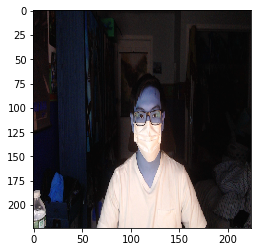

In [3]:
#Seeing how the images are being preprocessed.
train_folder_path = "custom_test/with_mask/"
for img in os.listdir(train_folder_path): # This will iterate in the Folder
    new_path = os.path.join(train_folder_path, img) # image Path

    try:        # if any image is corrupted
        image_data_temp = cv2.imread(new_path) # Read Image as numbers
        image_temp_resize = cv2.resize(image_data_temp,(224,224))
        plt.imshow(image_temp_resize, interpolation='nearest')
        plt.show()
    except Exception as e:
        print(e)

# Loading Images Into Usable Datasets

In [3]:
data_path = 'data/'

In [4]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [5]:
a = ImageLoader(PATH=data_path, IMAGE_SIZE=224, name="real")
image_Data,label_Data = a.load_dataset()
image_Data,label_Data = unison_shuffled_copies(image_Data,label_Data)
print(image_Data.shape)

Reading Dataset from PIckle Object
(8988, 224, 224, 3)


In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((image_Data[0:6293], label_Data[0:6293]))#70% of images
val_dataset = tf.data.Dataset.from_tensor_slices((image_Data[6293:7191], label_Data[6293:7191]))#~10% of images
test_dataset = image_Data[7191:]#~20% of images
test_label_dataset = label_Data[7191:]
# test_dataset = tf.data.Dataset.from_tensor_slices((image_Data[4465:], label_Data[4465:]))#~50% of images
train_dataset = train_dataset.batch(64)
val_dataset = val_dataset.batch(64)
# test_dataset = test_dataset.batch(64)

# Training Model

In [10]:
tf.keras.backend.clear_session()

model = keras.Sequential(
    [
        keras.Input(shape=(224, 224, 3)),
        layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid")
    ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [13]:
rms = RMSprop(learning_rate=0.0001, decay=1e-6)
model.compile(optimizer=rms, loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision()])

In [14]:
# make batches
callbacks = [keras.callbacks.ModelCheckpoint(filepath="maskCallback.keras", save_best_only=True, monitor="val_loss")]
history = model.fit(train_dataset,validation_data=val_dataset, batch_size=64, epochs=5, callbacks=callbacks)

Epoch 1/5
99/99 [==============================] - 152s 2s/step - loss: 0.4828 - precision: 0.7641 - val_loss: 0.2864 - val_precision: 0.8732
Epoch 2/5
99/99 [==============================] - 148s 1s/step - loss: 0.3125 - precision: 0.8655 - val_loss: 0.2462 - val_precision: 0.8859
Epoch 3/5
99/99 [==============================] - 150s 2s/step - loss: 0.2750 - precision: 0.8764 - val_loss: 0.2253 - val_precision: 0.8965
Epoch 4/5
99/99 [==============================] - 148s 1s/step - loss: 0.2472 - precision: 0.8954 - val_loss: 0.1996 - val_precision: 0.9102
Epoch 5/5
99/99 [==============================] - 153s 2s/step - loss: 0.2151 - precision: 0.9085 - val_loss: 0.1931 - val_precision: 0.9467


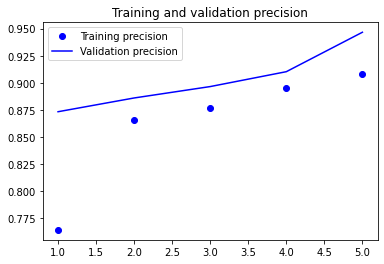

In [15]:
precision = history.history["precision"]
val_precision = history.history["val_precision"]
epochs = range(1, len(precision) + 1)
plt.plot(epochs, precision, "bo", label="Training precision")
plt.plot(epochs, val_precision, "b", label="Validation precision")
plt.title("Training and validation precision")
plt.legend()

In [16]:
#y_test=model.predict(test_dataset)
score = model.evaluate(test_dataset, test_label_dataset, verbose = 1) 

print('Test loss:', score[0]) 
print('Test precision:', score[1])

57/57 [==============================] - 13s 185ms/step - loss: 0.1682 - precision: 0.9522
Test loss: 0.16817627847194672
Test precision: 0.9522222280502319


# Saving The Model

In [17]:
model.save('models/mymodel.h5', save_format='h5')

# Loading Model

In [18]:
loaded_model = keras.models.load_model("models/mymodel.h5")

In [19]:
score = loaded_model.evaluate(test_dataset, test_label_dataset, verbose = 1) 

print('Test loss:', score[0]) 
print('Test precision:', score[1])

57/57 [==============================] - 13s 185ms/step - loss: 0.1682 - precision: 0.9522
Test loss: 0.16817627847194672
Test precision: 0.9522222280502319


# Analyzing Data

In [21]:
b = ImageLoader(PATH="custom_test/", IMAGE_SIZE=224, name="custom")
test_image_Data,test_label_Data = b.load_dataset()
score = loaded_model.evaluate(test_image_Data, test_label_Data, verbose = 1) 
print('Test loss:', score[0]) 
print('Test precision:', score[1])

Reading Dataset from PIckle Object
1/1 [==============================] - 2s 2s/step - loss: 0.1750 - precision: 1.0000
Test loss: 0.1750098168849945
Test precision: 1.0


In [14]:
def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

In [27]:
test_results=loaded_model.predict(test_dataset)
test_results = np.round(test_results, 0)

57/57 [==============================] - 13s 186ms/step


Found Categories  ['without_mask', 'with_mask'] 

[[1.]
 [1.]
 [0.]
 ...
 [1.]
 [0.]
 [1.]]
tf.Tensor(
[[829  43]
 [ 68 857]], shape=(2, 2), dtype=int32)


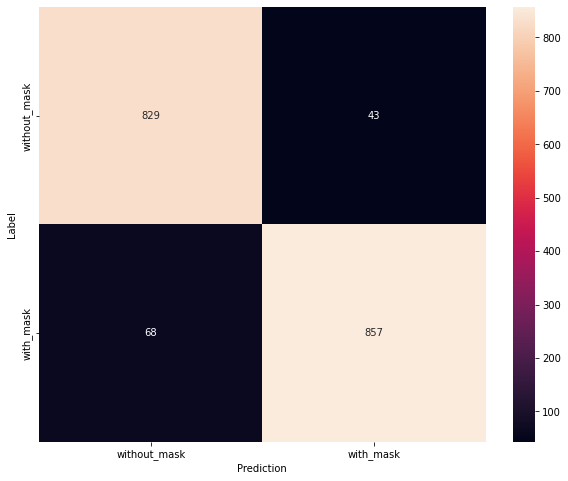

In [28]:
label_names = a.get_categories()
print(test_results)
confusion_mtx = tf.math.confusion_matrix(test_label_dataset, test_results, num_classes=len(label_names))
print(confusion_mtx)
show_confusion_matrix(confusion_mtx, label_names)

In [8]:
old_model = keras.models.load_model("models/keras_model.h5", compile=True)

In [23]:
label_names = a.get_categories()
old_test_results = old_model.predict(test_dataset)
old_test_results = np.round(old_test_results, 0)
print(old_test_results.shape)
print(old_test_results)
old_test_results = [x[0] for x in old_test_results]

Found Categories  ['without_mask', 'with_mask'] 

57/57 [==============================] - 10s 178ms/step
(1797, 2)
[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]


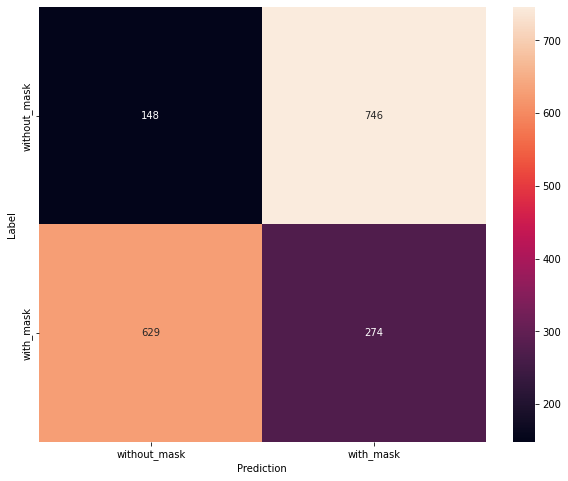

In [27]:
old_confusion_mtx = tf.math.confusion_matrix(test_label_dataset, old_test_results, num_classes=len(label_names))
show_confusion_matrix(old_confusion_mtx, label_names)